In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import time
from matplotlib import pyplot as plt

# GoogLeNet的PyTorch复现（猫狗大战）

## 1. 数据集制作

在论文中作者使用的是ILSVRC 2012比赛数据集，该数据集非常大（有138G），下载、训练都很消耗时间，我们在复现的时候就不用这个数据集了。由于MNIST、CIFAR10、CIFAR100这些数据集图片尺寸都较小，不符合GoogLeNet网络输入尺寸227x227的要求，因此我们改用kaggle比赛经典的“猫狗大战”数据集了。

该数据集包含的训练集总共25000张图片，猫狗各12500张，带标签；测试集总共12500张，不带标签。我们仅使用带标签的25000张图片，分别拿出2500张猫和狗的图片作为模型的验证集。我们按照以下目录层级结构，将数据集图片放好。

![](./images/path.png)

为了方便大家训练，我们将该数据集放在百度云盘，下载链接： 链接：https://pan.baidu.com/s/1UEOzxWWMLCUoLTxdWUkB4A 提取码：cdue

### 1.1 制作图片数据的索引

准备好数据集之后，我们需要用PyTorch来读取并制作可以用来训练和测试的数据集。对于训练集和测试集，首先要分别制作对应的图片数据索引，即train.txt和test.txt两个文件，每个txt中包含每个图片的目录和对应类别class（cat对应的label=0，dog对应的label=1）。示意图如下：

![](./images/index.png)

制作图片数据索引train.txt和test.txt两个文件的python脚本程序如下：

In [2]:
import os

train_txt_path = os.path.join("data", "catVSdog", "train.txt")
train_dir = os.path.join("data", "catVSdog", "train_data")
valid_txt_path = os.path.join("data", "catVSdog", "test.txt")
valid_dir = os.path.join("data", "catVSdog", "test_data")

def gen_txt(txt_path, img_dir):
    f = open(txt_path, 'w')
    
    for root, s_dirs, _ in os.walk(img_dir, topdown=True):  # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)             # 获取各类的文件夹 绝对路径
            img_list = os.listdir(i_dir)                    # 获取类别文件夹下所有png图片的路径
            for i in range(len(img_list)):
                if not img_list[i].endswith('jpg'):         # 若不是png文件，跳过
                    continue
                #label = (img_list[i].split('.')[0] == 'cat')? 0 : 1 
                label = img_list[i].split('.')[0]
                # 将字符类别转为整型类型表示
                if label == 'cat':
                    label = '0'
                else:
                    label = '1'
                img_path = os.path.join(i_dir, img_list[i])
                line = img_path + ' ' + label + '\n'
                f.write(line)
    f.close()

if __name__ == '__main__':
    gen_txt(train_txt_path, train_dir)
    gen_txt(valid_txt_path, valid_dir)

运行脚本之后就在./data/catVSdog/目录下生成train.txt和test.txt两个索引文件。

### 1.2 构建Dataset子类

PyTorch 加载自己的数据集，需要写一个继承自torch.utils.data中Dataset类，并修改其中的__init__方法、__getitem__方法、__len__方法。默认加载的都是图片，__init__的目的是得到一个包含数据和标签的list，每个元素能找到图片位置和其对应标签。然后用__getitem__方法得到每个元素的图像像素矩阵和标签，返回img和label。

In [3]:
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1]))) # 类别转为整型int
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB') 
        #img = Image.open(fn)
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
    def __len__(self):
        return len(self.imgs)

getitem是核心函数。self.imgs是一个list，self.imgs[index]是一个str，包含图片路径，图片标签，这些信息是从上面生成的txt文件中读取；利用Image.open对图片进行读取，注意这里的img是单通道还是三通道的；self.transform(img)对图片进行处理，这个transform里边可以实现减均值、除标准差、随机裁剪、旋转、翻转、放射变换等操作。

### 1.3 加载数据集和数据预处理

当Mydataset构建好，剩下的操作就交给DataLoder来加载数据集。在DataLoder中，会触发Mydataset中的getiterm函数读取一张图片的数据和标签，并拼接成一个batch返回，作为模型真正的输入。

In [4]:
pipline_train = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  #随机旋转图片
    #将图片尺寸resize到224x224
    transforms.Resize((224,224)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到224x224
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
train_data = MyDataset('./data/catVSdog/train.txt', transform=pipline_train)
test_data = MyDataset('./data/catVSdog/test.txt', transform=pipline_test)

#train_data 和test_data包含多有的训练与测试数据，调用DataLoader批量加载
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)
# 类别信息也是需要我们给定的
classes = ('cat', 'dog') # 对应label=0，label=1

在数据预处理中，我们将图片尺寸调整到224x224，符合VGGNet网络的输入要求。均值mean = [0.5, 0.5, 0.5]，方差std = [0.5, 0.5, 0.5]，然后使用transforms.Normalize进行归一化操作。

我们来看一下最终制作的数据集图片和它们对应的标签：

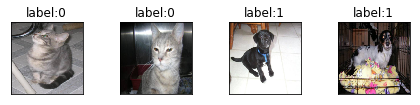

In [5]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_label) = next(examples)
# 批量展示图片
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout()  #自动调整子图参数，使之填充整个图像区域
    img = example_data[i]
    img = img.numpy() # FloatTensor转为ndarray
    img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
    img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
    #img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(img)
    plt.title("label:{}".format(example_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 2. 搭建GoogLeNet神经网络结构

In [6]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        #------ 输入块 ------#
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)
        
        #------ Inception 4a/4b ------#
        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        #------ 辅助分类器 1 ------#
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        #------ Inception 4b/4c/4d ------# 
        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        #------ 辅助分类器 2 ------#
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        #------ Inception 4e/5a/5b ------# 
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        #------ 输出块 ------# 
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

上面定义了完整的GoogLeNet V1网络。需要注意的是，类`Inception`定义了 Inception 模块的网络结构：

In [7]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

![](./images/inception.png)

类`InceptionAux`定义了辅助分类器模块的结构，辅助分类器只在训练的时候使用：

In [8]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

![](./images/aux1.png)

上图是辅助分类器 aux1 的结构图，aux2 结构与 aux1 完全相同。

GoogLeNet整体的网络结构可参照下图：

![](./images/structure.png)

定义GoogLeNet类的时候，参数num_classes指的是类别的数量，由于我们这里的数据集只有猫和狗两个类别，因此这里的全连接层的神经元个数做了微调。num_classes=2，输出层也是两个神经元，不是原来的1000个神经元。这里的改动大家注意一下，根据实际数据集的类别数量进行调整。整个网络的其它结构跟论文中的完全一样。

函数initialize_weights()是对网络参数进行初始化操作，这里我们默认选择关闭初始化操作。

## 3. 将定义好的网络结构搭载到GPU/CPU，并定义优化器

In [9]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "googlenet"
model = GoogLeNet(num_classes=2, aux_logits=True, init_weights=True)
model.to(device)
#定义优化器
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

这里我们将参数init_weights设为True，进行参数初始化操作。

## 4. 定义训练过程

In [10]:
def train_runner(model, device, trainloader, loss_function, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        #outputs = model(inputs)
        logits, aux_logits2, aux_logits1 = model(inputs)
        #计算损失和
        #loss = F.cross_entropy(outputs, labels)
        loss0 = loss_function(logits, labels)
        loss1 = loss_function(aux_logits1, labels)
        loss2 = loss_function(aux_logits2, labels)
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = logits.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 100 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

## 5. 定义测试过程

In [11]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 6. 运行

start_time 2022-02-24 15:02:41
Train Epoch1 	 Loss: 7.684023, accuracy: 51.562500%
Train Epoch1 	 Loss: 1.043524, accuracy: 56.451114%
Train Epoch1 	 Loss: 1.064129, accuracy: 58.869714%
Train Epoch1 	 Loss: 1.019752, accuracy: 61.638289%
test_avarage_loss: 0.019144, accuracy: 66.360000%
end_time:  2022-02-24 15:05:25 

start_time 2022-02-24 15:05:25
Train Epoch2 	 Loss: 1.106810, accuracy: 62.500000%
Train Epoch2 	 Loss: 0.887823, accuracy: 68.827351%
Train Epoch2 	 Loss: 0.700395, accuracy: 71.571828%
Train Epoch2 	 Loss: 0.919984, accuracy: 73.312915%
test_avarage_loss: 0.013472, accuracy: 80.480000%
end_time:  2022-02-24 15:08:06 

start_time 2022-02-24 15:08:06
Train Epoch3 	 Loss: 0.652730, accuracy: 84.375000%
Train Epoch3 	 Loss: 0.631292, accuracy: 77.970297%
Train Epoch3 	 Loss: 0.903582, accuracy: 79.213308%
Train Epoch3 	 Loss: 0.604491, accuracy: 79.962625%
test_avarage_loss: 0.011365, accuracy: 83.340000%
end_time:  2022-02-24 15:10:44 

start_time 2022-02-24 15:10:44
Tra

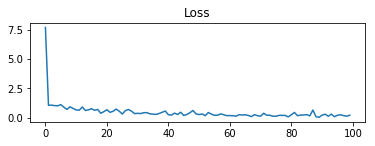

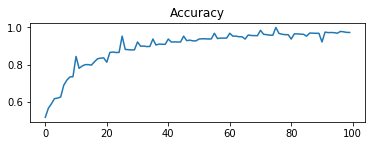

In [12]:
#调用
epoch = 20
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, loss_function, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 7. 保存模型

In [15]:
print(model)
torch.save(model, './models/googlenet-catvsdog.pth') #保存模型

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), paddin

## 8. 模型测试

下面使用一张猫狗大战测试集的图片进行模型的测试。

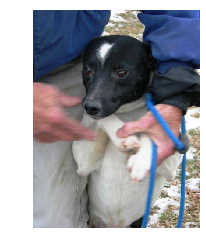

概率： tensor([[0.0825, 0.9175]], device='cuda:0', grad_fn=<SoftmaxBackward>)
预测类别： dog


In [16]:
from PIL import Image
import numpy as np

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/googlenet-catvsdog.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # 读取要预测的图片
    img = Image.open("./images/test_dog.jpg") # 读取图像
    #img.show()
    plt.imshow(img) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    # 预测 
    classes = ('cat', 'dog')
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是2个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("预测类别：",pred_class)